In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Azzahra\.conda\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("bank-full.csv", delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## EDA

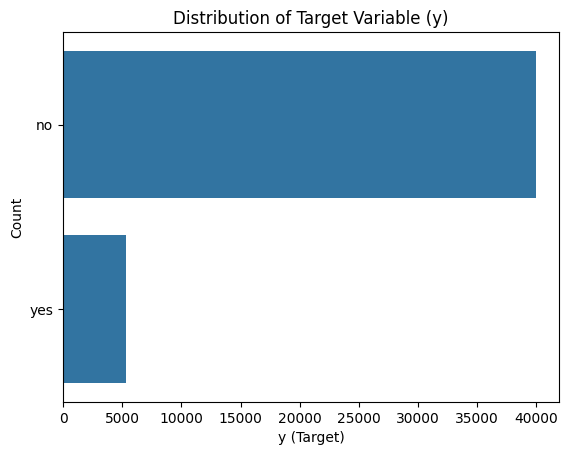

In [5]:
# Distribution of target variable 'y'
sns.countplot(data['y'])
plt.title('Distribution of Target Variable (y)')
plt.xlabel('y (Target)')
plt.ylabel('Count')
plt.show()

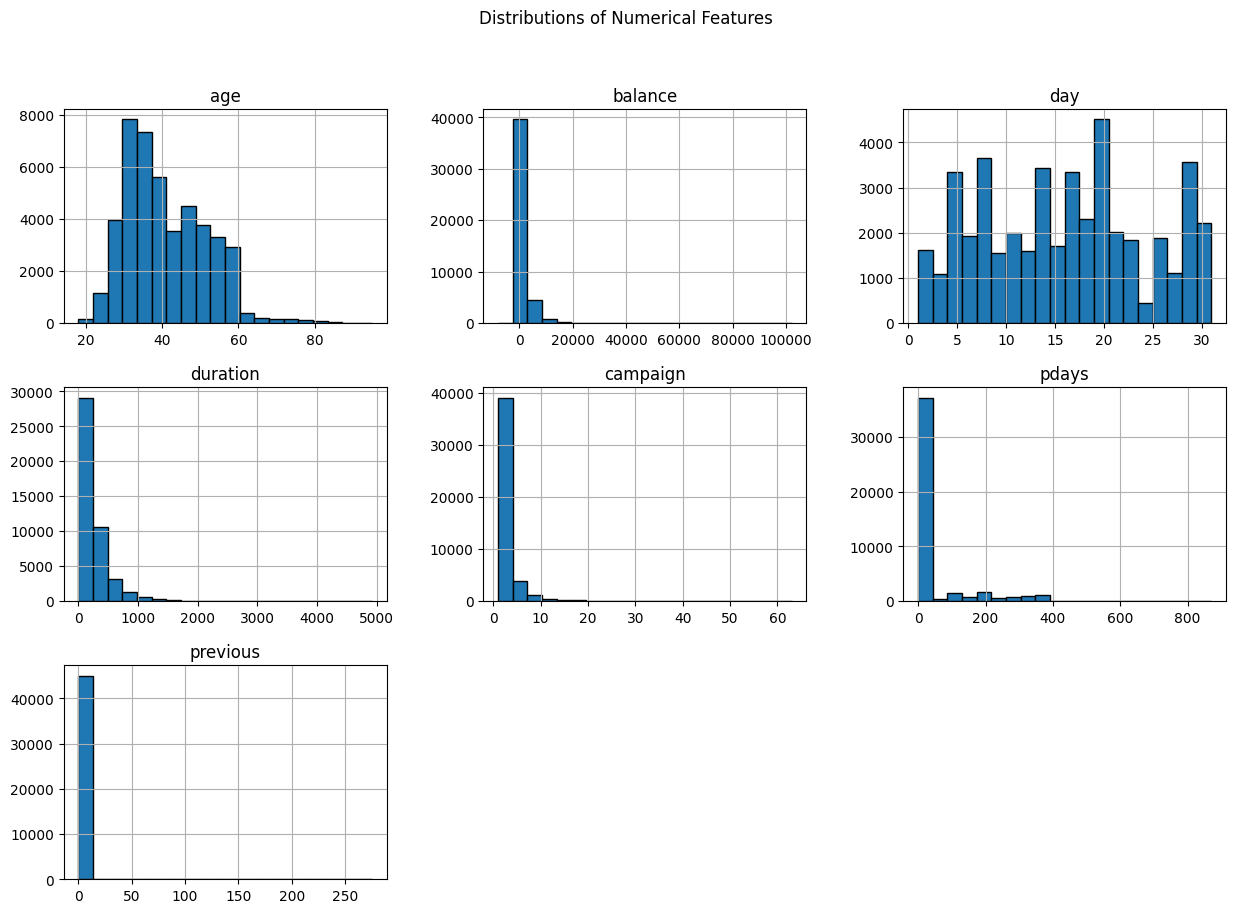

In [6]:
# Distribution of numerical variables
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
data[numerical_cols].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Distributions of Numerical Features')
plt.show()

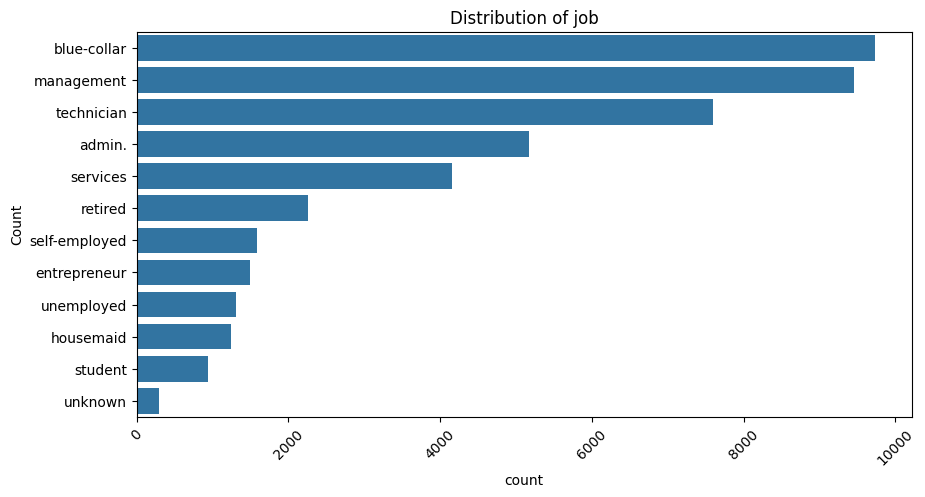

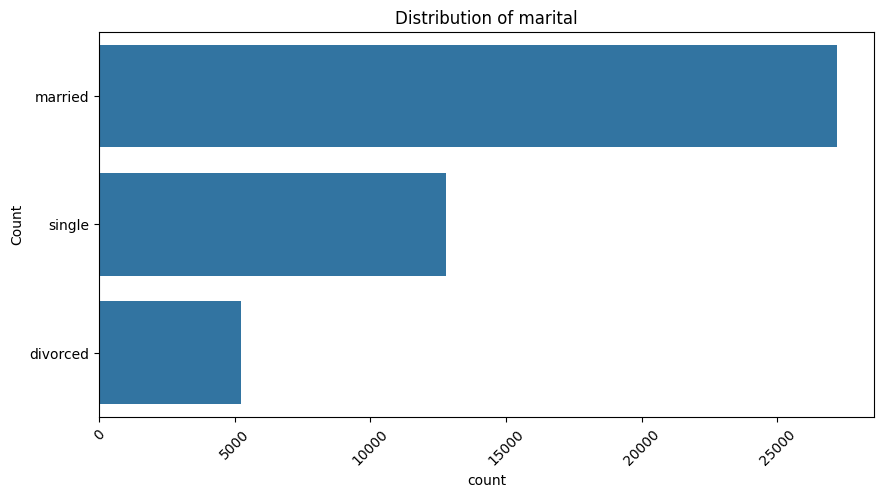

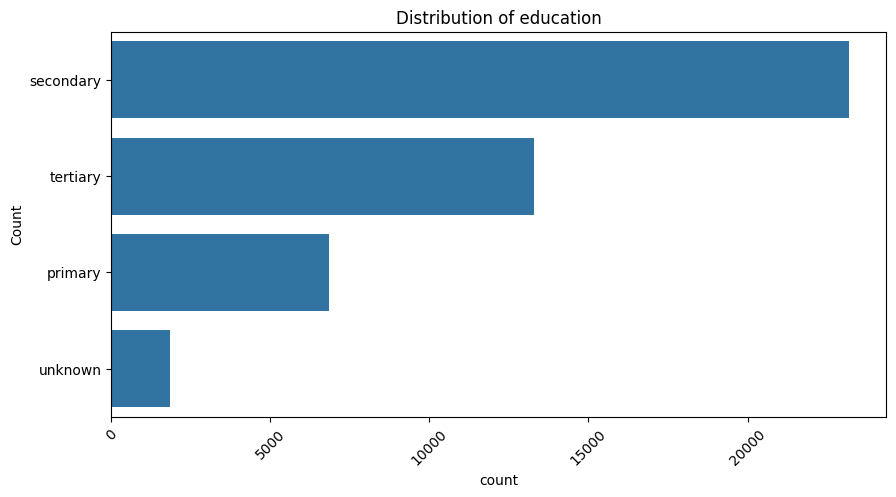

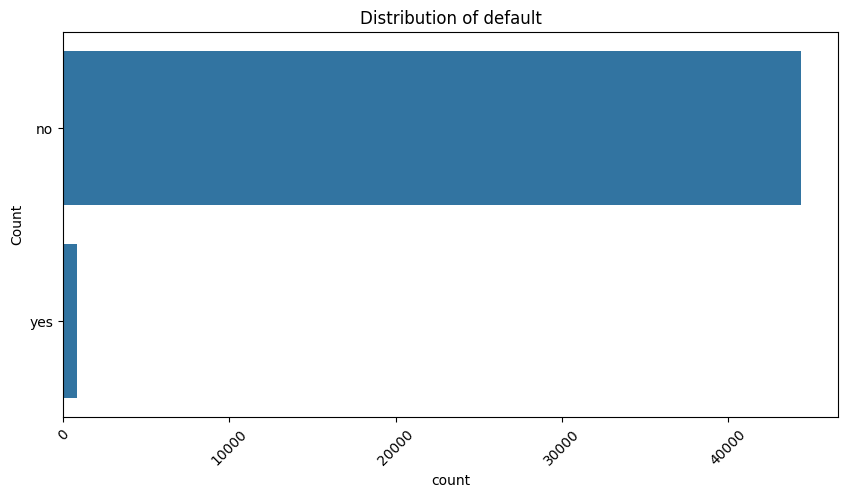

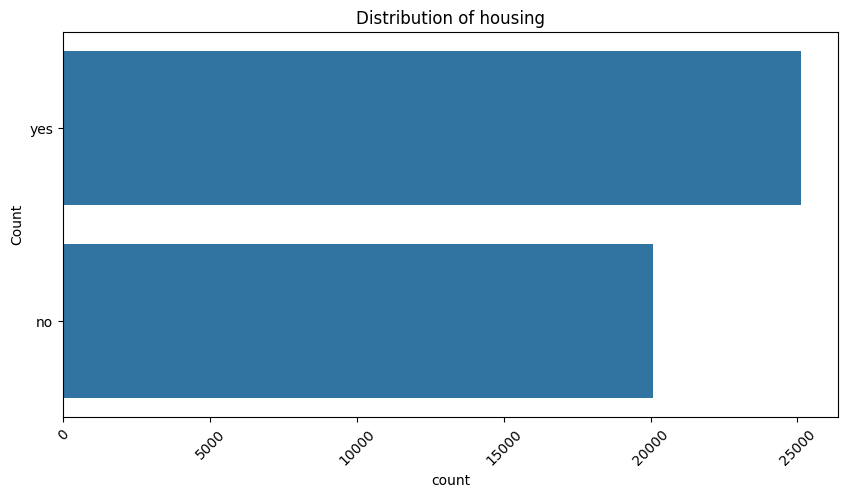

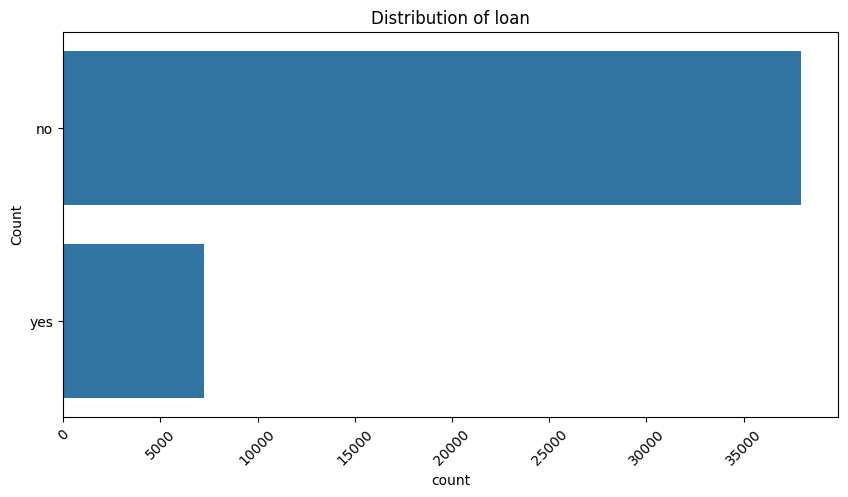

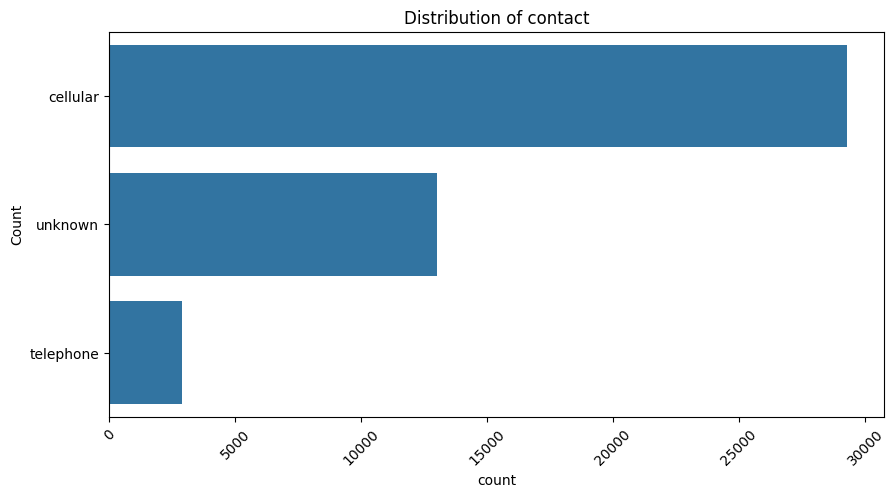

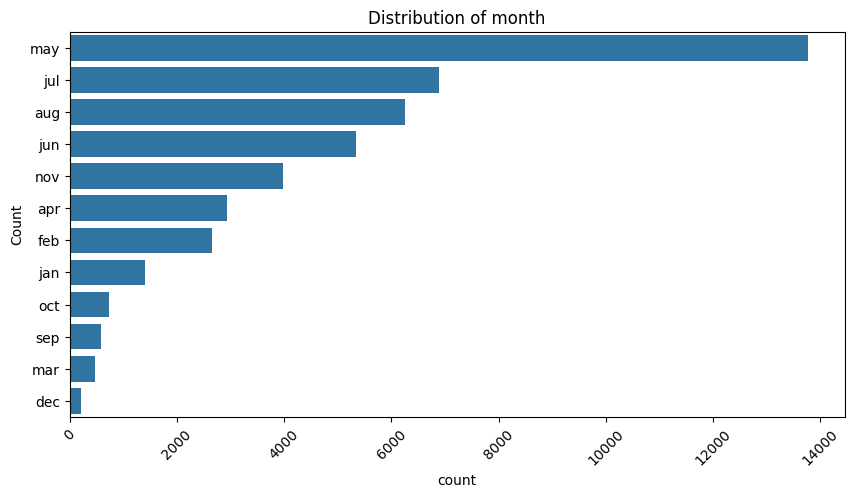

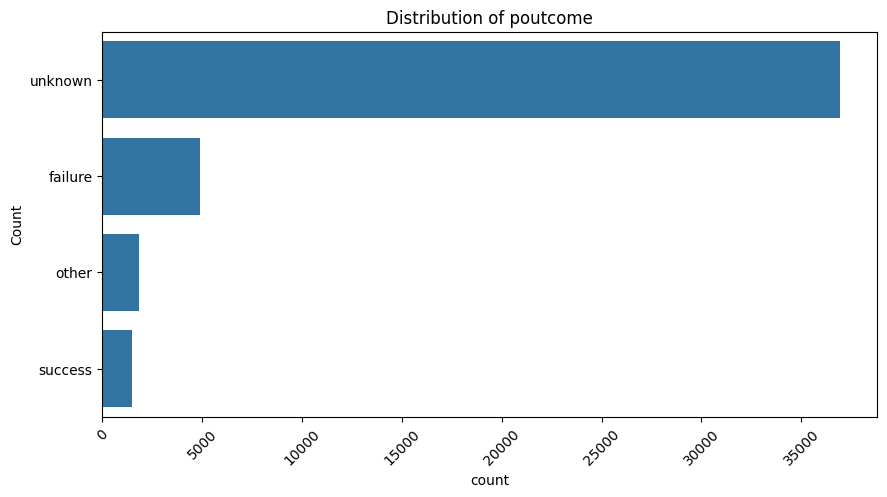

In [7]:
# Categorical variables analysis
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data[col], order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

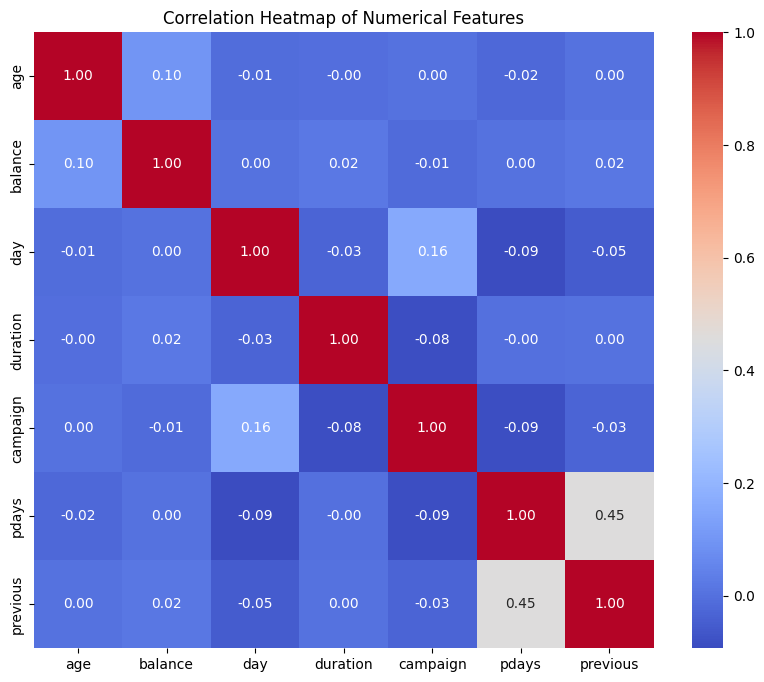

In [8]:
# Correlation heatmap for numerical features
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

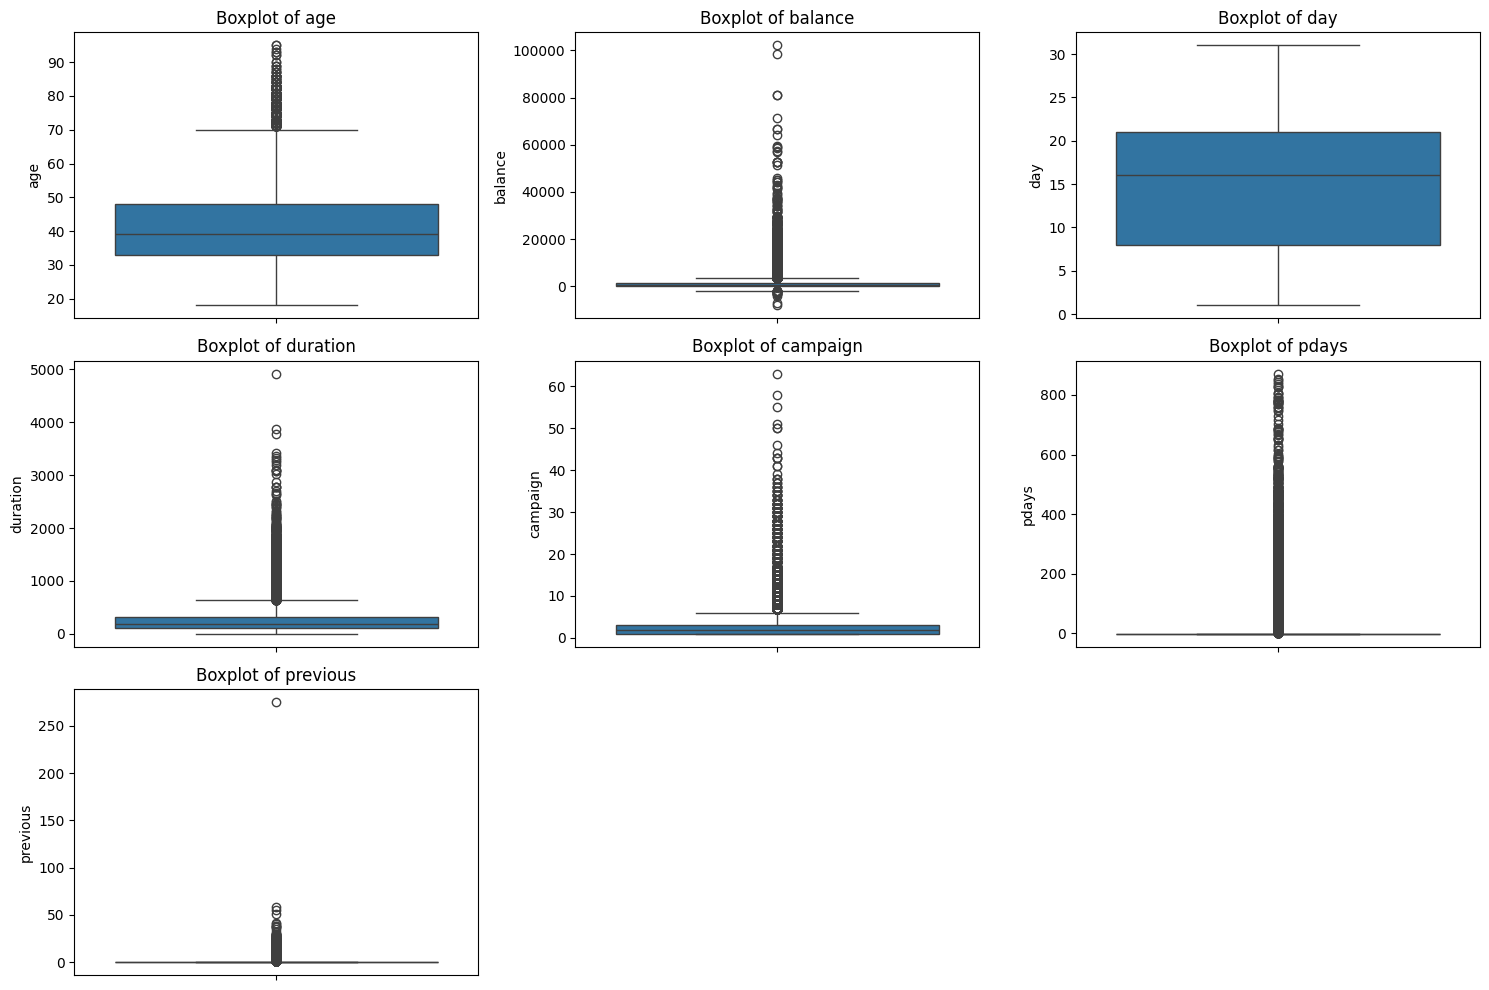

In [9]:
# Boxplot to check outliers in numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


## MARKOV

In [10]:
# Preprocessing
def preprocess_data(data):
    X = data.drop('y', axis=1)
    X = pd.get_dummies(X)
    y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(data)

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [11]:
# Define RNN for Markov Model
class RNNMarkovNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling='max'):
        super(RNNMarkovNet, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == 'max':
            out = torch.max(out, dim=1).values
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out


In [12]:
# Train RNN Markov Model
def train_rnn_markov_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader):
    best_loss = float('inf')
    patience_counter = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs.squeeze(), y_batch)
                test_loss += loss.item()
                predictions = torch.round(torch.sigmoid(outputs.squeeze()))
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)
        test_loss /= len(test_loader)
        accuracy = correct / total

        scheduler.step(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > early_stopper:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    return accuracy

In [13]:
# Experiment with RNN Markov Model
hidden_sizes = [32, 64]
poolings = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]
optimizers = ['SGD', 'RMSprop', 'Adam']
early_stopper = 10

results_rnn_markov = []
for hidden_size in hidden_sizes:
    for pooling in poolings:
        for optimizer_name in optimizers:
            for num_epochs in epochs_list:
                print("=====================================================================")
                print(f"\nConfiguration: RNN Markov Hidden Size={hidden_size}, Pooling={pooling}, Optimizer={optimizer_name}, Epochs={num_epochs}")
                model = RNNMarkovNet(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=1, output_size=1, pooling=pooling)
                criterion = nn.BCEWithLogitsLoss()

                if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.01)

                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
                accuracy = train_rnn_markov_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader)

                results_rnn_markov.append({
                    'Model': 'RNN MarkovNet',
                    'Hidden Size': hidden_size,
                    'Pooling': pooling,
                    'Optimizer': optimizer_name,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy
                })

results_rnn_markov_df = pd.DataFrame(results_rnn_markov)
results_rnn_markov_df.to_csv('rnn_markov_experiment_results.csv', index=False)


Configuration: RNN Markov Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Train Loss: 0.4022, Test Loss: 0.3072, Accuracy: 0.8826
Epoch 2/5, Train Loss: 0.2711, Test Loss: 0.2587, Accuracy: 0.8944
Epoch 3/5, Train Loss: 0.2443, Test Loss: 0.2459, Accuracy: 0.8986
Epoch 4/5, Train Loss: 0.2366, Test Loss: 0.2419, Accuracy: 0.8995
Epoch 5/5, Train Loss: 0.2337, Test Loss: 0.2401, Accuracy: 0.9004

Configuration: RNN Markov Hidden Size=32, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Train Loss: 0.3959, Test Loss: 0.2936, Accuracy: 0.8882
Epoch 2/50, Train Loss: 0.2625, Test Loss: 0.2561, Accuracy: 0.8953
Epoch 3/50, Train Loss: 0.2422, Test Loss: 0.2466, Accuracy: 0.8980
Epoch 4/50, Train Loss: 0.2363, Test Loss: 0.2435, Accuracy: 0.8990
Epoch 5/50, Train Loss: 0.2341, Test Loss: 0.2422, Accuracy: 0.9000
Epoch 6/50, Train Loss: 0.2326, Test Loss: 0.2411, Accuracy: 0.8997
Epoch 7/50, Train Loss: 0.2329, Test Loss: 0.2404, Accuracy: 0.9004
Epoch 8/50, Train Loss: 0.23

## Hidden Markov

In [14]:
# Prepare sequences for HMM
data['job'] = data['job'].astype('category').cat.codes
sequence = data['job'].values
train_seq, test_seq = train_test_split(sequence, test_size=0.2, random_state=42)

# Train Hidden Markov Model
def train_hmm(sequence, n_components):
    hmm_model = hmm.MultinomialHMM(n_components=n_components, n_iter=100, random_state=42)
    sequence = np.array(sequence).reshape(-1, 1)
    hmm_model.fit(sequence)
    return hmm_model

hmm_hidden_states = [2, 3, 5, 7]
hmm_results = []

for n_components in hmm_hidden_states:
    hmm_model = train_hmm(train_seq, n_components=n_components)
    log_likelihood = hmm_model.score(np.array(test_seq).reshape(-1, 1))
    hmm_results.append({
        'Model': 'Hidden Markov Model',
        'Hidden States': n_components,
        'Log Likelihood': log_likelihood
    })

hmm_results_df = pd.DataFrame(hmm_results)
hmm_results_df.to_csv('hmm_experiment_results.csv', index=False)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows

## KESIMPULAN

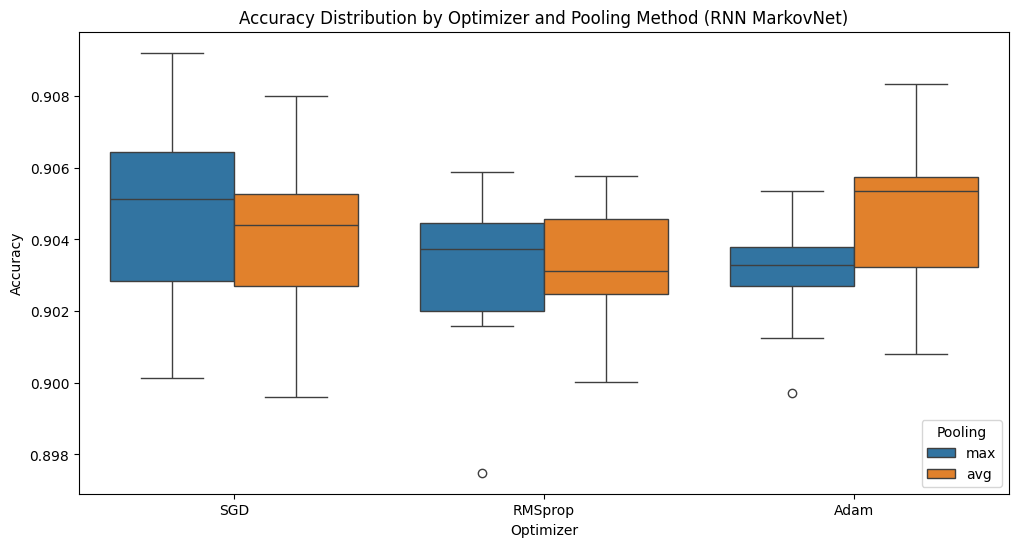

In [15]:
# Visualize Results
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_rnn_markov_df, x='Optimizer', y='Accuracy', hue='Pooling')
plt.title('Accuracy Distribution by Optimizer and Pooling Method (RNN MarkovNet)')
plt.ylabel('Accuracy')
plt.xlabel('Optimizer')
plt.legend(title='Pooling', loc='lower right')
plt.savefig('rnn_markov_accuracy_distribution.png')
plt.show()

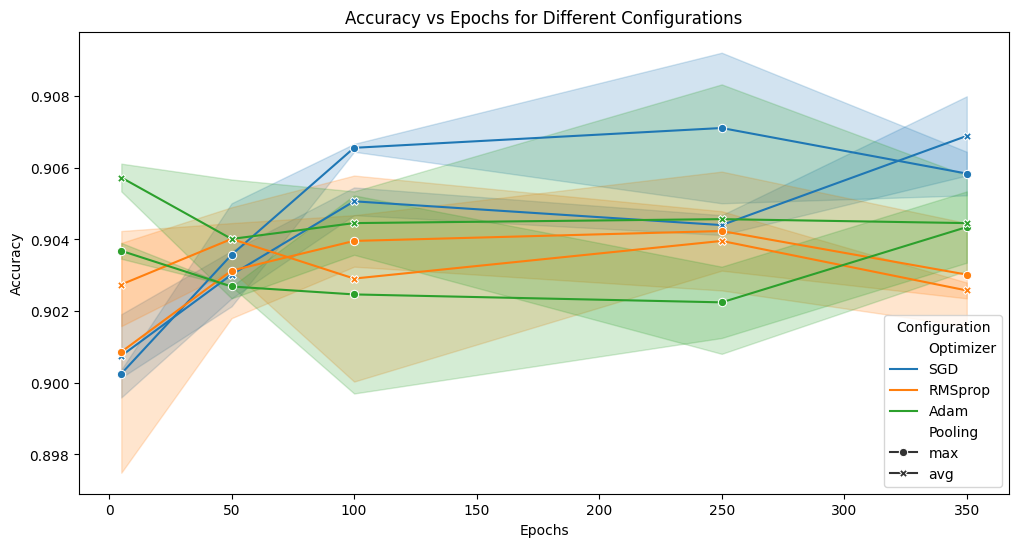

In [18]:
    # Plot Accuracy vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_rnn_markov_df, x='Epochs', y='Accuracy', hue='Optimizer', style='Pooling', markers=True, dashes=False)
plt.title('Accuracy vs Epochs for Different Configurations')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(title='Configuration', loc='lower right')
plt.savefig('accuracy_vs_epochs.png')
plt.show()



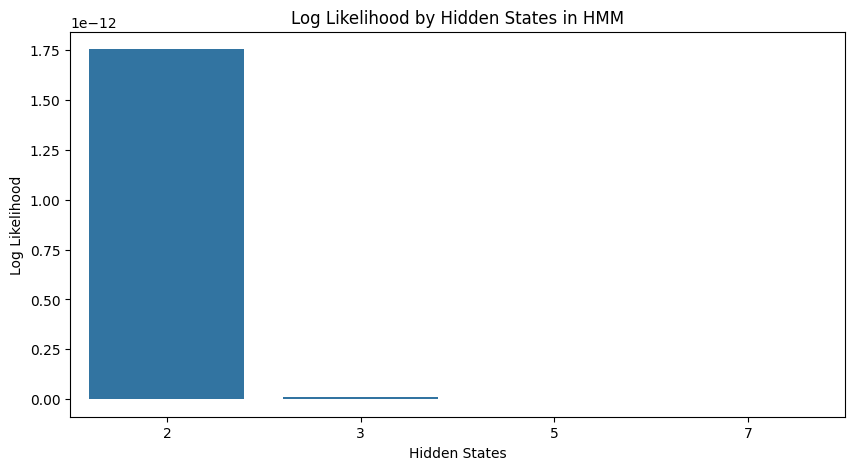

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(data=hmm_results_df, x='Hidden States', y='Log Likelihood')
plt.title('Log Likelihood by Hidden States in HMM')
plt.ylabel('Log Likelihood')
plt.xlabel('Hidden States')
plt.savefig('hmm_log_likelihood.png')
plt.show()


In [20]:
# Combine Results and Top 10 Configurations
combined_results = results_rnn_markov_df

top_10 = combined_results.sort_values(by='Accuracy', ascending=False).head(10)
print("Top 10 Configurations by Accuracy:")

# Save as table
from tabulate import tabulate
print(tabulate(top_10, headers='keys', tablefmt='pretty', showindex=False))


Top 10 Configurations by Accuracy:
+---------------+-------------+---------+-----------+--------+--------------------+
|     Model     | Hidden Size | Pooling | Optimizer | Epochs |      Accuracy      |
+---------------+-------------+---------+-----------+--------+--------------------+
| RNN MarkovNet |     64      |   max   |    SGD    |  250   | 0.9092115448413136 |
| RNN MarkovNet |     32      |   avg   |   Adam    |  250   | 0.9083268826716796 |
| RNN MarkovNet |     64      |   avg   |    SGD    |  350   | 0.907995134358067  |
| RNN MarkovNet |     32      |   max   |    SGD    |  100   | 0.906668141103616  |
| RNN MarkovNet |     64      |   max   |    SGD    |  350   | 0.9064469755612076 |
| RNN MarkovNet |     64      |   max   |    SGD    |  100   | 0.9064469755612076 |
| RNN MarkovNet |     64      |   avg   |   Adam    |   5    | 0.9061152272475947 |
| RNN MarkovNet |     32      |   max   |  RMSprop  |  250   | 0.9058940617051864 |
| RNN MarkovNet |     32      |   avg   |